In [ ]:
### import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as lin

from IPython.display import Image


#plt.rcParams['text.usetex'] = True

def border(x,y):
    return x*y + np.cos(x*y)

def dist_to_border(x,y):
    return 1 - np.sqrt(x*x+y*y)

def random_on_circle(x,y,r):
    th = np.random.random()*2*np.pi
    return x + r*np.cos(th),y + r*np.sin(th)

def wos(x,y):
    d = dist_to_border(x,y)
    if d < 0:
        return 0
    while d > 1e-3:
        x,y = random_on_circle(x,y,d)
        d = dist_to_border(x,y)
    return border(x,y)

def wos_solve(x,y):
    E = 0
    MC = 200
    for i in range(MC):
        E += wos(x,y)
    return E/MC


def brownian(N):
    dx = 0.001
    X = [i*dx for i in range(N)]
    Y = [0]
    for i in range(N-1):
        Y.append(Y[-1] + np.sqrt(dx)*np.random.randn(1)[0])
    return X,Y

def laplace(N):
    X = np.linspace(-1.0,1.0,N)
    Y = np.linspace(-1.0,1.0,N)
    Z = np.zeros((N,N))
    for j in range(N):
        for i in range(N):
            Z[i,j] = wos_solve(X[i],Y[j])
    return Z

def random_is_cool():
    f = plt.figure(figsize=(15,5))
    ax1 = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    X,Y = brownian(1000)
    ax1.plot(X,Y)
    Z = laplace(30)
    ax2.imshow(Z)
    
def stopping_time():
    N = 1
    Y = [0]
    h = 0.01
    while abs(Y[-1]) < 1:
        Y.append(Y[-1] + np.sqrt(h)*np.random.randn(1)[0])
        N += 1
    tau = N*h
    X = [i*h for i in range(N)]
    return X,Y,tau

def plot_stopping_time():
    taus = []
    f = plt.figure(figsize=(15,5))
    ax1 = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    N = 10000
    for i in range(N):
        X,Y,tau = stopping_time()
        if i % 1000 == 0:
            ax1.plot(X,Y)
        taus.append(tau)
    n, bins,patches = ax2.hist(taus,50,density=True)

# Calcul stochastique et Applications à la modélisation et aux EDP
## Outils Maths
#### Baptiste GENEST - 2022

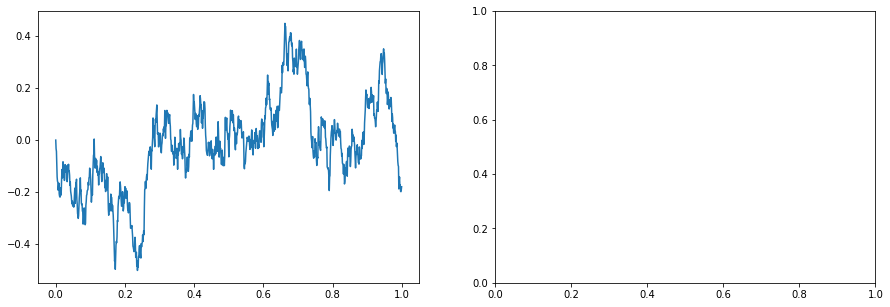

In [24]:
random_is_cool()

## Pourquoi ce sujet ?
Je tombe sur un article de Keenan Crane qui parle de MCGP : 
    C'est génial!

- Comment contribuer? 
    - Soit par l'amélioration de l'approche Monte-Carlo, proche de ce qui se fait en rendu (Control Variate, etc...)
    - Soit par progrès théoriques en calcul stochastique/EDP

- J'achète un bouquin : "Calcul stochastique et modèles de diffusions"
- On s'y intéresse très vite par pur intérêt scientifique: 
    - Liens hautement non triviaux pour l'intuition entre Processus aléatoires et résolution d'EDP

## Pourquoi le calcul stochastique ?
La modélisation par équation différentielle est vaste mais souhaiter introduire de l'aléatoire est une impulsion très naturelle:

Très peu de chance que le modèle soit exact, on peut introduire de l'aléa:

- Par réalisme : 
    - Si on simule le comportement d'animaux, même si on peut décrire les influences sur les comportements par des EDO, il y a toujours des comportements erratiques.
- Par humilité : 
    - un peu perdu : on peut introduire du bruit pour prendre en compte les forces qu'on pourrait oublier/négliger.
    - complètement perdu : l'évolution de la bourse est souvent trop imprévisible pour des modèles différentiels.

## Qu'est ce que le calcul stochastique ?

* L'étude des processus aléatoires et de leurs intéractions avec différentes questions d'analyse. Par exemple: 

     - Peut-on coupler la notion d'équation différentielle avec les phénomènes aléatoires ? (oui)
     - Si j'ai une fonction $\varphi$ et un mouvement aléatoire $X$, qu'est ce que je peux dire sur $\varphi(X(t))$ ? (plein de choses)
     - Est-ce que l'ajout d'aléatoire peut nous aider à résoudre des problèmes déterministes? (double oui)

## Notion de processus stochastique:
Une application $X$ est un processus stochastique à valeur dans $E$ indexée par $\mathbb{T}$ si
$$ 
\forall t \in \mathbb{T},X(t) : \omega \rightarrow X(t,\omega) \text{ est une variable aléatoire dans } E
$$

Un processus aléatoire est caractérisée par la loi que ses valeurs peuvent prendre, souvent en fonction de $t$.


Par exemple, on peut regarder espérance selon le temps et la covariance entre deux instants du processus:
$$
m(t) = \mathbb{E}(X(t))
\\
\Gamma(s,t) = \text{Cov}(X(t),X(s))
$$

## Exemple nul: Bruit blanc gaussien
Equivalent d'une suite de variables indépendantes
$$
    \mathbb{E}(N(t)) = 0 \\
    \text{Cov}(N(t),N(s)) = \delta_{s-t}
$$

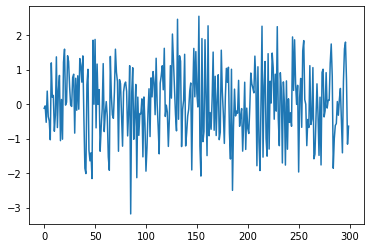

In [3]:
def gaussian_white_noise(N):
    return np.random.randn(N)
plt.plot(gaussian_white_noise(300))
plt.show()

## Example fondamental : Le mouvement brownien

<img style="float: right;" src="brownian_motion.gif" width="350"/>
$$
\begin{cases}
    B(0) = 0 \\
    B(t+h) - B(t) \sim \mathcal{N}(0,h)
\end{cases}
$$


## Comment on manipule des fonctions aléatoires?
Souvent, on prend une subdivision d'un intervalle $I = [a,b], a = t_1\leq t_2 \leq \dots \leq t_n = b$ 
- Utile pour définir des propriétés:
    - Un processus est à accroissements indépendants si $\forall n, X(t_2) - X(t_1), \dots ,X(t_n) - X(t_{n-1})$ sont indépendants
    - Un processus est Gaussien si $\forall n, (X(t_1), \dots ,X(t_n))$ est un vecteur gaussien
    
(Par exemple le mouvement brownien vérifie ces deux propriétés.)

   - Utile pour prouver des propriétés

Prouvons que le mouvement brownien n'est monotone sur aucun intervalle:
Il suffit de montrer que pour tout $s,t \in \mathbb{Q}$ l'évènement suivant est de probabilité nulle:
$$
E = \{ \omega \in \Omega, B(\omega) \text{ est croissante sur } [s,t] \} 
$$

$\forall n \in \mathbb{N}$, on définit l'évènement
$$
E_n = \bigcap_{1\leq k \leq n} \{ \omega \in \Omega, B(s + k\frac{t-s}{n}) - B(s+(k-1)\frac{t-s}{n}) \geq 0 \}
$$

On remarque que
$$
\mathbb{P}(B(s + k\frac{t-s}{n}) - B(s+(k-1)\frac{t-s}{n}) \geq 0) = \mathbb{P}(\mathcal{N}(0,\frac{t-s}{n}) \geq 0) = \frac{1}{2}
$$

Par indépendances des accroissements du mouvement brownien B, on a alors
$$
\mathbb{P}(E) = \lim_{n\to \infty} \mathbb{P}(E_n) = \lim_{n\to \infty} (\frac{1}{2})^n \to 0
$$

## Un autre moyen naturel d'étudier un processus stochastique
### Les temps d'arrêt
Un temps d'arrêt $\tau$ est une variable aléatoire qui dépend d'un processus stochastique. 

Par exemple: Le temps de sortie d'un intervalle:
$$
    \tau = \min_{t>0} B(t) \notin [-1,1]
$$

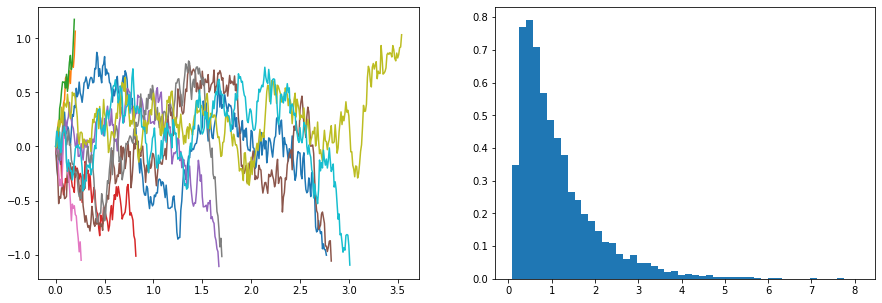

In [4]:
plot_stopping_time()

## "Dériver" le mouvement brownien?
<img style="float: right;" src="brownian_motion.gif" width="200"/>

On s'attend à ce que le mouvement brownien vérifie.
$$
\frac{d B(t)}{dt} = N(t)
$$
où $N(t)$ est un bruit blanc gaussien.

Malheuresement $\frac{d B(t)}{dt}$ n'a pas de sens, car 
$$
\frac{d B(t)}{dt} = \lim_{h\to 0} \frac{B(t+h) - B(t)}{h} \sim \mathcal{N}(0,\frac{1}{h})
$$
Mais tout n'est pas à jeter! Même si la dérivée n'a pas de sens, la différentielle oui!

$$
dB(t) = N(t)dt
$$
On préserve la relation *dérivée - primitive* entre le mouvement brownien et le bruit blanc, mais on présentera le bruit blanc sous la forme $dB(t)$ parce que plus facile à manipuler. 

## L'approche inverse: le processus à partir de sa différentielle?
Supposons qu'on ne connaisse pas $X$, mais $dX$ 
$$
    dX = dB
$$
Comme dans le cas déterministe, si on fixe bien les conditions initiales:
$$
    \implies X(t) = B(t)
$$
Et si on voulait moduler l'intensité du bruit blanc?

par exemple:
$$
    dX(t) = \sigma(X(t),t)dB(t)?
$$

Pourquoi ne pas rajouter un terme déterministe?
$$
dX(t) = b(X(t),t)dt + \sigma(X(t),t)dB(t)
$$

C'est une **équation différentielle stochastique!** (si $\sigma = 0$ on retrouve une équation différentielle classique)

## Résoudre une EDS théoriquement
### Intégrale stochastique
Si on a
$$
dX(t) = b(X(t),t)dt + \sigma(X(t),t)dB(t)
$$
Alors la solution est donnée par:
$$
X(t) = X(0) + \int_0^t b(X(t),t)dt + \int_0^t \sigma(X(t),t)dB(t)
$$

## Résoudre une EDS en pratique
### Méthodes numériques:
#### Euler explicite:
On prend juste $dt$ petit et $dB(t) \approx B(t+dt) - B(t) \sim \mathcal{N}(0,dt)$ 

In [5]:
def normal(mu,sigma2):
    return mu + np.random.randn()*np.sqrt(sigma2)

In [6]:
def euler_explicit(x0,b,sigma,dt,N,t0 = 0):
    X = [x0]*N
    t = t0
    for i in range(1,N):
        xt = X[i-1]
        X[i] = xt + dt*b(xt,t) + sigma(xt,t)* normal(0,dt)
        t += dt
    return X

Par exemple, pour $$
\begin{cases}
X(0) = 1 \\
dX(t) = X(t)dt + \frac{dB(t)}{1+t}
\end{cases}
$$

In [7]:
def sigma(x,t):
    return 1/(1+t)
def b(x,t):
    return x

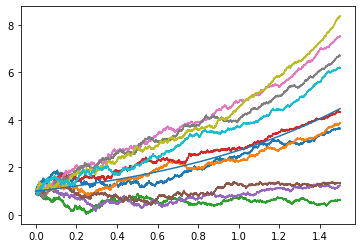

In [8]:
dt = 0.0001
N = int(1.5/dt)
X = [dt*i for i in range(N)]
for i in range(10):
    plt.plot(X,euler_explicit(1,b,sigma,dt,N))
plt.plot(X,np.exp(X))
plt.show()

## Exemple d'EDS
### Le recuit simulé
<img style="float: right;" src="recuit_simule.png" width="400"/>
Supposons qu'on cherche à trouver le minimum global d'une fonction périodique $U$, une descente de gradient ne nous donne aucune garantie de tomber sur le minimum global (dépend de $x_0$). 

Introduire un bruit qui décroit avec le temps peut nous permettre de sortir des minimums locaux!
$$
dX(t) = -\nabla U(X(t))dt + \sigma(t)dB(t)
$$

En pratique on attend pas que le bruit décroisse parce qu'il doit décroitre vraiment très lentement pour être sûr de converger asympotiquement:  $ \sigma(t) = \mathcal{O}( \frac{1}{\sqrt{\log(t)}}) $

## Equation d'ordre 2
Supposons qu'on veuille décrire une trajectoire d'une particule dont on connait les forces qui s'appliquent sur elles.

Par le PFD:
$$
X''(t) = \Sigma_i F_i(X(t),t)
$$

Si ces forces sont aléatoires:


On l'adapte par 2 équations différentielles stochastiques
$$
\begin{align*}
dX(t) &= V(t) dt \\
dV(t) &= -\beta V(t)dt + F(X(t),t)dB(t)
\end{align*}
$$


<img style="float: right;" src="kolmogorov.jpg" width="350"/>

# Avant de passer aux liens avec les EDP
## Est-ce que tout est clair?



<p style="text-align:center"> <i> "The epistemological value of probability theory is based on the fact that chance phenomena, considered collectively and on a grand scale, create non-random regularity" </i> </p>
<p style="text-align:right"> <b> Andreï Kolmogorov </b> </p>



### Un mouton à la montagne

Supposons qu'on ait une fonction $\phi$ qui représente une carte de hauteur, et $X$ la position d'un mouton, (qu'on suppose décrite par une EDS $dX = b dt + \sigma dB$), si on sait qu'à l'instant 0, le mouton est au point x, est-ce qu'on peut prédire vaguement à quelle hauteur sera le mouton après un temps t? 

$$
\begin{align*}
    \mathbb{E}(\phi(X(t))| X(0) = x) &= \mathbb{E}_x(\phi(X(t))
\end{align*}
$$

$$
    u(x,t) = (P_t(\phi))(x) = \mathbb{E}_x(\phi(X(t))
$$

Que vaut $\frac{\partial u}{\partial t}$ ?

$$
    \frac{\partial u}{\partial t}(x,t) = \sum_{i = 0}^n b_i(x)\frac{\partial u}{\partial x_i}(x,t) + \sum_{0\leq i,j\leq n} a_{ij}(x) \frac{\partial^2 u}{\partial x_i \partial x_j}(x,t)) \\
    \text{où } a(x) = \sigma(x)\sigma(x)^T
$$

$$
\begin{align*}
    \frac{du}{dt} &= \langle b,\nabla u \rangle + \text{tr}(a^Tu'') \\
    &= \langle b,\nabla u \rangle + \langle a,u'' \rangle \\
    \text{ où }u'' &\text{ est la hessienne de } u
\end{align*}
$$

In [9]:
def covariance():
    N = 1000
    X = np.random.randn(N)
    Y = np.random.randn(N)
    f = plt.figure(figsize=(15,5))
    ax1 = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    A = 2*X + 3*Y
    B = 3*X + Y
    ax1.scatter(X,Y)
    ax1.set_title(r'$dB \sim \mathcal{N}(0,Id)$',fontsize=30)
    ax2.set_title(r'$\sigma(x) dB \sim \mathcal{N}(0,\sigma(x)\sigma(x)^T)$',fontsize=30,)
    ax2.scatter(A,B)

Pourquoi $\sigma \sigma^T$ ?

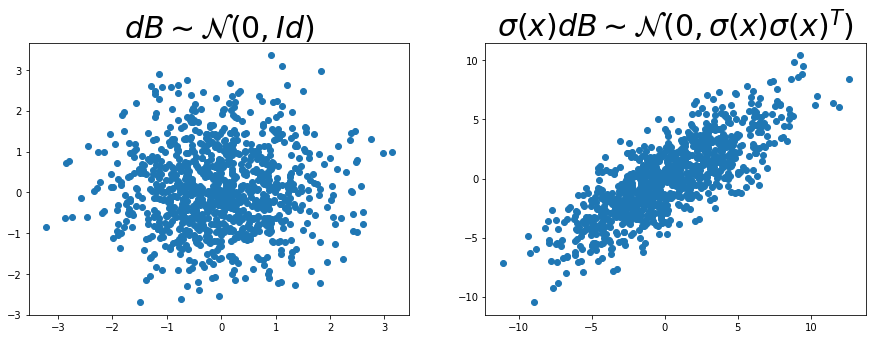

In [10]:
covariance()

donc 
$$
\frac{du}{dt} = \underbrace{\langle b,\nabla u \rangle}_{\text{Alignement entre partie déterministe et gradient}} + \underbrace{\langle a,u'' \rangle}_{\text{Alignement entre "forme du bruit" et le profil au second ordre}}
$$

### L'opérateur par rapport au mouvement Brownien
pour le mouvement brownien, $b = 0, \sigma = Id$, on a:
$$
\begin{align*}
    \frac{du}{dt} &= tr(u'')\\ &= \Delta u
\end{align*}
$$

ça implique que calculer
$$
u(x,t) = \mathbb{E}_x(u_0(B(t))
$$
permet de calculer la solution du problème
$$
\begin{cases}
    \frac{du}{dt}(x,t) &= \Delta u(x,t) \\
    u(x,0) &= u_0(x)
\end{cases}
$$

$$
\mathbb{E}_x(u_0(B(t)) = \lim_{n\rightarrow \infty} \frac{1}{n}\sum_{i = 0}^n u_0(B_i(t))
$$

## Pour l'équation de Laplace
<img style="float: right;" src="laplace.png" width="350"/>
$$
\begin{cases}
\Delta u(x) = 0, x \in \Omega \\
u(x) = f(x), x \in \partial \Omega
\end{cases}
$$

#### Correspond moralement à la limite temporelle de l'équation de la chaleur dans un domaine bornée
$$
    \lim_{t\mapsto \infty} u(x,t)
$$
Inutile de simuler jusqu'à l'infini! Une idée très élégante:
$$
u(x) = \mathbb{E}_x(u(B(\tau_{\Omega}))) = \mathbb{E}_x(f(B(\tau_{\Omega})))
$$
*Drunk men as valid interpolation estimators*

## Walk On Sphere
En réalité, on peut se passer de simuler un mouvement brownien par somme de bruit blanc.
<img style="float: right;" src="wos.png" width="500"/>

Gros gain de vitesse!

In [1]:
def walk_on_sphere(x,f,N,eps):
    s = 0
    for i in range(N):
        X = x
        while dist_to_border(X) > eps:
            X = uniform_on_sphere(X,dist_to_border(X))
        s += f(X)
    return s/N

## Equation de poisson
$$
\begin{cases}
\Delta u(x) = g(x), x \in \Omega \\
u(x) = f(x), x \in \partial \Omega
\end{cases}
$$
Se traduit limpidement par
$$
u(x) = \mathbb{E}_x(f(B(\tau_{\Omega}) + \int_0^{\tau_{\Omega}} g(B(t)) dt)
$$

<img style="float: right;" src="robust.png"  width="800"/>

## Comparaison par rapport à une approche élément finie
Les \+:
* Plus de maillage! Juste besoin d\'une query de distance
* Convergence pointwise
* Simplicité algorithmique
* Parallélisation (!)
* Robuste

<img style="float: right;" src="surfacic.png"  width="400"/>

Les \-:
* Limité à une classe très restreinte d'EDP (elliptique)
* Plus lent pour les problèmes simples
* Uniquement volumique (?)
